# Post-hoc Background Event Filtering

Compare volunteer labelled transit locations to the background flux at that location to check for background events.

- Get the top 500 results (ground truth for whether it is a transit or a background event)
- Load the corresponding fits files and get the true and background flux
- Load the transit locations from the volunteers
- Visualise the background and true flux a cut out around the transit
- Make a classifier for whether there is an outlier in the background at the same point as the transit. 

## Load and Visualise data

In [21]:
import sys
print(sys.executable)

/Users/shreshth/anaconda3/envs/pht-ml/bin/python


In [80]:
import os

from glob import glob

from ast import literal_eval

import astropy.io.fits as pf
from tqdm.autonotebook import trange

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import AutoMinorLocator

In [90]:
# ground truth classifications
SECTORS = [20]
# SECTORS = [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
# ROOT_PATH = "/mnt/zfsusers/shreshth/pht_project/data/"
ROOT_PATH = "/Users/shreshth/Library/CloudStorage/OneDrive-Nexus365/Projects/Planet Hunter/data"

def load_ground_truth(root_path, sectors):
    """
    Loads ground truth labels. 
    TODO: get TOI transit locations as well
    Returns:
    - df
    """
    df = pd.DataFrame()
    for sector in sectors:
        ground_truth_files = glob(os.path.join(root_path, f"labels/top_500_labels/all_ground_truth_{sector}.csv"))
        volunteer_files = glob(os.path.join(root_path, f"labels/transit_locs/transit_locs_sec_{sector}.csv"))
        toi_eb_files = glob(os.path.join(root_path, f"labels/top_500_labels_tois_ebs/all_ground_truth_{sector}.csv"))
        # need both files
        if len(ground_truth_files) == 0 or len(volunteer_files) == 0:
            continue
        df_sec = pd.read_csv(ground_truth_files[0])
        df_sec2 = pd.read_csv(volunteer_files[0], converters={"db_peak": literal_eval, "db_counts_weighted": literal_eval})


        # merge on TIC_ID
        df_sec = df_sec.merge(df_sec2, on="TIC_ID", how="left")

        df = pd.concat([df, df_sec], axis=0)
        
    # filter out no peaks
    print("filtering out no peaks, original length: ", len(df))
    df = df.loc[df['db_peak'].apply(lambda x: x != [0])]
    print("new length: ", len(df))

    return df


df = load_ground_truth(ROOT_PATH, SECTORS)
# label metrics
print(f"Total: {len(df)}")
print(f"planets: {len(df.loc[df['final_score'] == 'planet'])}")
print(f"Background: {len(df.loc[df['final_score'] == 'other'])}")
print(f"EBs: {len(df.loc[df['final_score'] == 'EB'])}")
df["bg"] = df["final_score"].apply(lambda x: True if x in ["other", "EB"] else False)

# print(f"No peaks: {len(df.loc[df['db_peak'] == [0]])}")
# print(df.loc[df['TIC_ID'] == 356473560])
df

filtering out no peaks, original length:  911
new length:  542
Total: 542
planets: 89
Background: 269
EBs: 184


,Unnamed: 0_x,TIC_ID,sector,TOI,TOI_t0,TOI_t0_sec,TOI_period,ctc_score,EB,EB_t0,EB_t0_sec,EB_period,final_score,Unnamed: 0_y,db_count_weighted,db_peak,bg
3,18,362103921,20,-99.0,-99.00000,-99.000000,-99.00000,3,1.0,1814.281949,1844.568212,10.095421,EB,18,[0.88060420727916888],[10.426575163906598],True
4,38,156921656,20,-99.0,-99.00000,-99.000000,-99.00000,2,1.0,1843.781996,1843.781996,4.349318,EB,38,"[0.7477515024763326, 0.7477515024763326, 0.747...","[1.2801780935185174, 5.614580189121649, 9.9652...",True
5,91,99391575,20,-99.0,-99.00000,-99.000000,-99.00000,2,1.0,1816.456204,1843.718873,2.726267,EB,91,"[0.75707695355461468, 0.75707695355461468, 0.7...","[1.1969271291671875, 3.922945153938216, 6.6400...",True
6,139,288979840,20,-99.0,-99.00000,-99.000000,-99.00000,-999,1.0,1816.928459,1842.916314,1.528697,EB,139,"[0.37179736924984086, 0.31151681903041151]","[5.619157022245037, 20.57426879080169]",True
7,159,154840461,20,1.0,2759.99969,1842.515498,6.03608,-999,1.0,1685.574672,1842.514742,6.036157,planet,159,"[1.0, 1.0, 1.0, 0.88410258785689377, 0.4556644...","[24.152563632650825, 18.129926113803993, 6.016...",False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905,19709,297962605,20,-99.0,-99.00000,-99.000000,-99.00000,3,-99.0,-99.000000,-99.000000,-99.000000,other,19709,"[0.51552297132511138, 0.2553057490276725]","[7.537162729843422, 24.234165889187143]",True
906,19723,68743185,20,-99.0,-99.00000,-99.000000,-99.00000,3,-99.0,-99.000000,-99.000000,-99.000000,other,19723,[0.51923940403829172],[6.073753217431031],True
907,19729,73194829,20,-99.0,-99.00000,-99.000000,-99.00000,3,-99.0,-99.000000,-99.000000,-99.000000,other,19729,"[0.38583676163555169, 0.26127520650629965]","[8.987973861460405, 25.812309965950398]",True
908,19738,16594889,20,-99.0,-99.00000,-99.000000,-99.00000,3,-99.0,-99.000000,-99.000000,-99.000000,other,19738,[0.93971242243730868],[22.00521627525975],True


    Unnamed: 0_x     TIC_ID  sector   TOI  TOI_t0  TOI_t0_sec  TOI_period  \
21           368  264300312      20 -99.0   -99.0       -99.0       -99.0   

    ctc_score    EB  EB_t0  EB_t0_sec  EB_period final_score  Unnamed: 0_y  \
21          3 -99.0  -99.0      -99.0      -99.0       other           368   

                                    db_count_weighted  \
21  [0.51900410167061584, 0.24658923252339726, 0.2...   

                                              db_peak    bg  
21  [16.8276355395314, 5.516266560650185, 25.03830...  True  


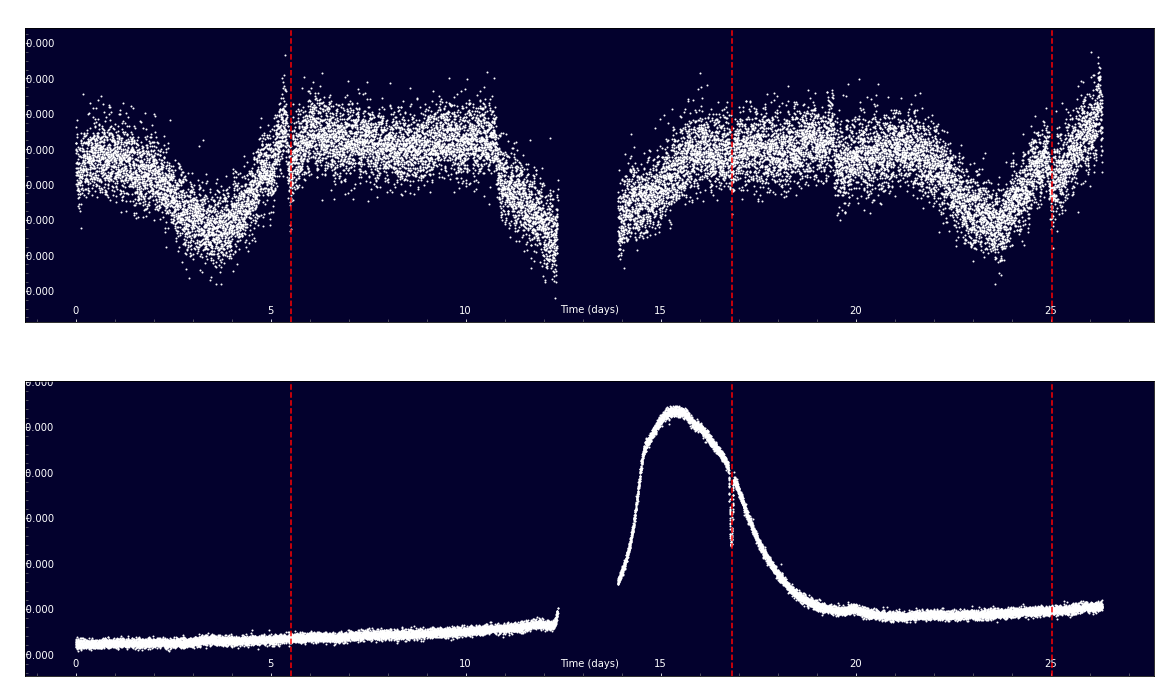

In [91]:
# fits files    

def _read_lc(lc_file):
    """Read light curve file (copy from data.py)
    Returns:
    - time (np.array): time array
    - flux (np.array): flux array
    - bg_flux (np.array): background flux array
    - file_name (str): file name
    """
    # open the file in context manager - catching corrupt files
    try:
        with pf.open(lc_file) as hdul:
            d = hdul[1].data
            hdr = hdul[1].header
            time = np.array(d["TIME"]).byteswap().newbyteorder()  # currently not using time
            flux = np.array(d["PDCSAP_FLUX"]).byteswap().newbyteorder() # the processed flux
            bg_flux = np.array(d["SAP_BKG"]).byteswap().newbyteorder()  # the background flux
            qual = d['QUALITY']

            # l = np.isfinite(time) * np.isfinite(flux) * (qual == 0)
            low_qual = (qual > 0)  # bad quality

            
            # remove bad data
            flux[low_qual] = np.nan
            bg_flux[low_qual] = np.nan

            t0 = time[0]  # make the time start at 0 (so that the timeline always runs from 0 to 27.8 days)
            time -= t0

            tic = int(hdul[0].header["TICID"])
            sec = int(hdul[0].header["SECTOR"])
            cam = int(hdul[0].header["CAMERA"])
            chi = int(hdul[0].header["CCD"])
            tessmag = hdul[0].header["TESSMAG"]
            teff = hdul[0].header["TEFF"]
            srad = hdul[0].header["RADIUS"]
            cdpp_0_5 =hdr["CDPP0_5"]
            cdpp_1_0 = hdr["CDPP1_0"]
            cdpp_2_0 = hdr["CDPP2_0"]

            file_name = f"tic-{tic}_sec-{sec}_cam-{cam}_chi-{chi}_tessmag-{tessmag}_teff-{teff}_srad-{srad}_cdpp05-{cdpp_0_5}_cdpp1-{cdpp_1_0}_cdpp2-{cdpp_2_0}"
    except:
        print("Error in fits file: ", lc_file)
        return None, None, None

    return time, flux, bg_flux, file_name

def plot_flux_and_background(df_peaks, tic_id, sector, root_path):
    """
    Get the light curve and plot it.
    also plot the peaks if available
    """

    # find the fits file
    # fits_file = glob(os.path.join(root_path, f"planethunters/Rel{sector}/Sector{sector}/**/*.fit*"), recursive=True)
    fits_files = glob(os.path.join(root_path, f"LC_fits/Sector{sector}/**/*{tic_id}*.fit*"), recursive=True)
    if len(fits_files) == 0:
        print(f"No fits file found for TIC {tic_id} in sector {sector}")
        return
    # else:
    #     print(f"Found {len(fits_files)} fits files for TIC {tic_id} in sector {sector}")
    time, flux, bg_flux, file_name = _read_lc(fits_files[0])
    ## define the plotting area
    fig, axs = plt.subplots(2, 1, figsize=(16, 10))
    plt.subplots_adjust(left=0.01, right=0.99, top=0.95, bottom=0.05)

    plot_lc(time, flux, ax=axs[0], title= f"Main Flux, TIC {tic_id}, Sector {sector}")
    plot_lc(time, bg_flux, ax=axs[1], title= f"Background Flux, TIC {tic_id}, Sector {sector}")

    # plot the peaks
    peaks = df_peaks.loc[(df_peaks['TIC_ID'] == tic_id) & (df_peaks['sector'] == sector)]
    print(peaks)
    if len(peaks) > 0:
        # peaks = np.fromstring(peaks['db_peak'].values[0][1:-1], sep=",")
        peaks = peaks['db_peak'].values[0]
        for peak in peaks:
            axs[0].axvline(x=peak, color='red', linestyle='--')
            axs[1].axvline(x=peak, color='red', linestyle='--')
    

def plot_lc(time, flux, title, ax):

    ax.plot(
        time,
        flux,
        color="white",
        marker="o",
        markersize=1,
        lw=0,
        label="raw",
    )
    ax.set_title(title, fontsize=20, color="white")


    ## define that length on the x axis - I don't want it to display the 0 point
    delta_flux = np.nanmax(flux) - np.nanmin(flux)

    ## set the y lim.
    percent_change = delta_flux * 0.1
    ax.set_ylim(np.nanmin(flux) - percent_change, np.nanmax(flux) + percent_change)

    ## label the axis.
    ax.xaxis.set_label_coords(0.063, 0.06)  # position of the x-axis label

    ## define tick marks/axis parameters

    minorLocator = AutoMinorLocator()
    ax.xaxis.set_minor_locator(minorLocator)
    ax.tick_params(direction="in", which="minor", colors="w", length=3, labelsize=13)

    minorLocator = AutoMinorLocator()
    ax.yaxis.set_minor_locator(minorLocator)
    ax.tick_params(direction="in", length=3, which="minor", colors="grey", labelsize=13)
    ax.yaxis.set_major_formatter(FormatStrFormatter("%.3f"))

    ax.tick_params(axis="y", direction="in", pad=-30, color="white", labelcolor="white")
    ax.tick_params(axis="x", direction="in", pad=-17, color="white", labelcolor="white")

    ax.set_xlabel("Time (days)", fontsize=10, color="white")

    # ax.set_axis_bgcolor("#03012d")  # depending on what version of Python you're using.
    ax.set_facecolor("#03012d")

# background flux examples: unclear (might need to zoom in): 252891043, 81214374, 147474957, 371706502 good: 264300312

# planet flux examples: unclear: 198384408, 288631580, 298073824, 159400561, good: 199688472, 158002130, 288132261
# eb flux examples: 362103921, 365936982, 353894978, 399788405, 147576476, 445030869
plot_flux_and_background(df, 264300312, 20, ROOT_PATH)    
# for tic_id in df.loc[df['final_score'] == 'EB']['TIC_ID']:
#     plot_flux_and_background(tic_id, 20, ROOT_PATH)

plt.show()

## Time series outlier classifier

Idea 1:
- get 1 day window
- Detrend on long time scale
- Short term rolling windows of mean, std, kurtosis. 
- Some logical condition based on those values

Idea 2:
- check for correlation between background and the real flux 
- but if there is nothing they will probs have high correlation?

Idea 3:
- anomaly detection algos. 

Evaluation:
- validation set


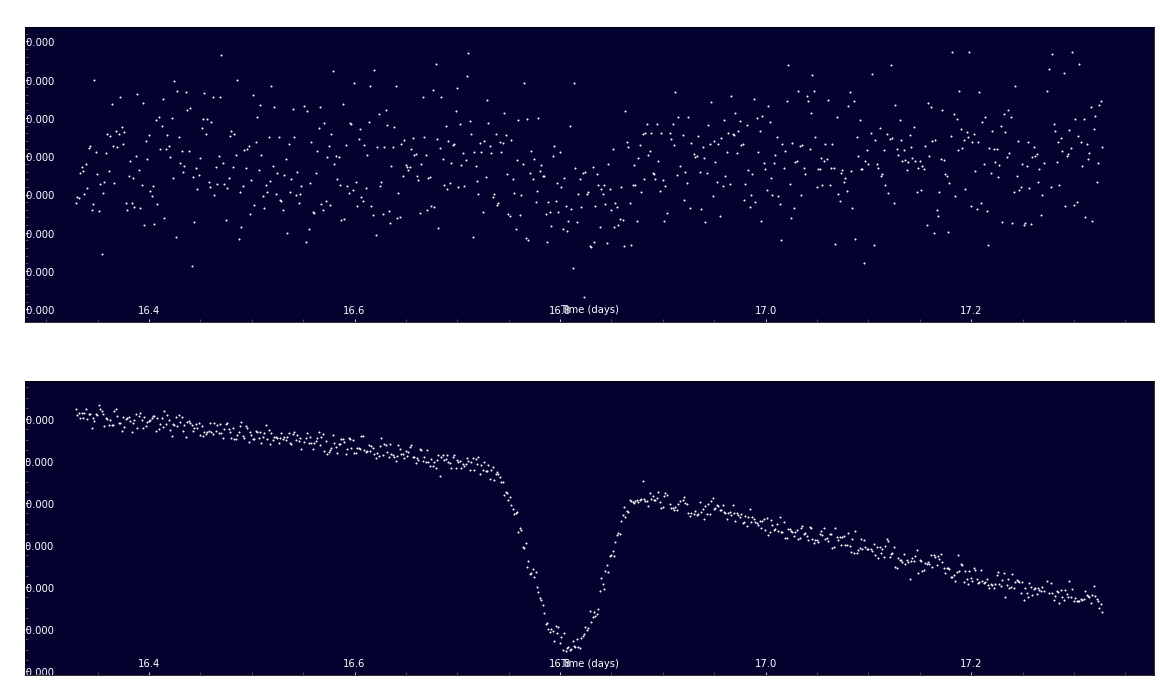

peak 0 is background:  True


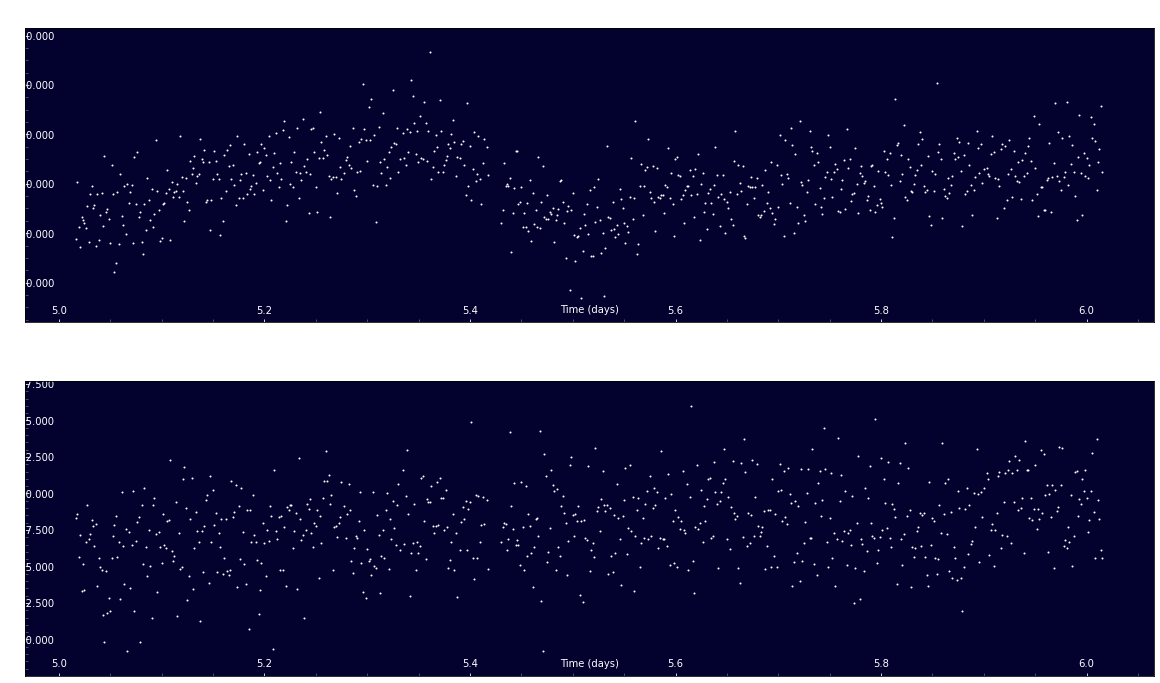

peak 1 is background:  False


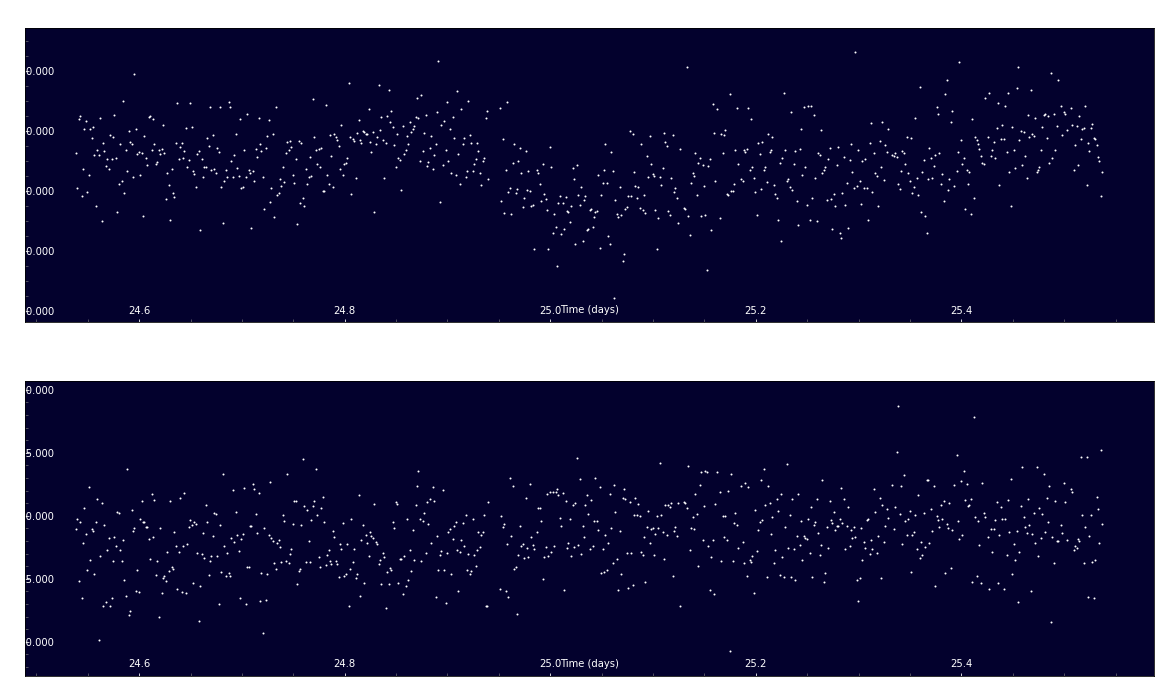

peak 2 is background:  False


False

In [92]:
# cut out 1 day window around each peak

def get_flux_window(window_length, peak, time, flux, bg_flux):
    """
    Get the flux window around a peak
    """
    start = peak - window_length/2
    end = peak + window_length/2
    flux_window = flux[(time >= start) & (time <= end)]
    bg_flux_window = bg_flux[(time >= start) & (time <= end)]
    time_window = time[(time >= start) & (time <= end)]
    return time_window, flux_window,  bg_flux_window

def plot_flux_window(window_length, peak, time, flux, bg_flux):
    """
    Plot a single peak
    """
    fig, axs = plt.subplots(2, 1, figsize=(16, 10))
    plt.subplots_adjust(left=0.01, right=0.99, top=0.95, bottom=0.05)

    time_window, flux_window,  bg_flux_window = get_flux_window(window_length, peak, time, flux, bg_flux)

    plot_lc(time_window, flux_window, ax=axs[0], title= f"Main Flux")
    plot_lc(time_window, bg_flux_window, ax=axs[1], title= f"Background Flux")

    plt.show()

def classify_lc_bg(df_peaks, tic_id, sector, root_path, window_length=1, classifier="std", z_score_threshold=5, lag=2/24):
    """
    window_length: length of the window in days
    """
    fits_files = glob(os.path.join(root_path, f"LC_fits/Sector{sector}/**/*{tic_id}*.fit*"), recursive=True)
    if len(fits_files) == 0:
        print(f"No fits file found for TIC {tic_id} in sector {sector}")
        return
    # else:
    #     print(f"Found {len(fits_files)} fits files for TIC {tic_id} in sector {sector}")
    time, flux, bg_flux, file_name = _read_lc(fits_files[0])

    # plot the peaks
    peaks = df_peaks.loc[(df_peaks['TIC_ID'] == tic_id) & (df_peaks['sector'] == sector)]
    if len(peaks) > 0:
        # peaks = np.fromstring(peaks['db_peak'].values[0][1:-1], sep=",")
        peaks = peaks['db_peak'].values[0]
        is_bg = True
        for i, peak in enumerate(peaks):
            plot_flux_window(window_length, peak, time, flux, bg_flux)
            # TODO classify bg flux instead of plotting
            time_window, flux_window, bg_flux_window = get_flux_window(window_length, peak, time, flux, bg_flux)
            # classify as background only if all peaks are background
            is_peak_bg = is_background_event(time_window, flux_window, bg_flux_window, classifier, z_score_threshold, lag)
            print("peak", i, "is background: ", is_peak_bg)
            is_bg = is_bg and is_peak_bg

    return is_bg

def std_classifier(time_window, flux_window, bg_flux_window, z_score_threshold, lag):
    """
    This classifier uses the standard deviation of the background flux to classify the peak. 
    It computes the standard deviation of the background flux in a rolling window of size lag.
    If the rolling standard deviation changes by more than z_score_threshold around the peak, this is classified as a backoground event.
    - z_score_threshold: the threshold for the z-score of the peak
    - Lag should be set to the width of the transit
    TODO: also add kurtosis and mean as features to classify if required.
    """
    # rolling window
    time_step = time_window[1] - time_window[0]
    lag_step = int(lag / time_step)
    # print(lag_step)

    # check if there is a big deviation in the middle of the window
    bg = pd.Series(bg_flux_window)
    # rolling std window 
    bg_std = bg.rolling(window=lag_step, min_periods=1).std()
    # bg_std_mean = bg_std.rolling(window=lag_step, min_periods=1).mean()

    bg_std_median = bg_std.median()
    # print(bg_std_median)
    # bg_std.plot()
    # plt.show()
    # plt.clf()

    # check if the flux is outside of the mean +- k*std in the middle of the window
    # bg_z_score = (bg - bg_mean) / bg_std
    # subtract median std

    bg_z_score = bg_std - bg_std_median
    # bg_z_score.plot()
    # check if the z score is above the threshold anywhere near the middle of the window
    return (bg_z_score[len(bg_z_score)//2 - lag_step//2:len(bg_z_score)//2 + lag_step//2] > z_score_threshold).any()
    
    

def is_background_event(time_window, flux_window, bg_flux_window, classifier="std", z_score_threshold=5, lag=2/24):
    """
    Classify the background flux by checking if there is a big deviation in the flux in the middle of the window
    Params:
        classifier: which classifier to use
        z_score_threshold: threshold for the z score
        lag: width of the transit in days
    """
    if classifier == "std":
        return std_classifier(time_window, flux_window, bg_flux_window, z_score_threshold, lag)
    else:
        raise ValueError(f"Classifier {classifier} not implemented")


classify_lc_bg(df, 264300312, 20, ROOT_PATH, window_length=1)

In [97]:
# classify all of the peaks
def classify_lcs(row, root_path, window_length=1, classifier="std", z_score_threshold=5, lag=2/24):
    """
    window_length: length of the window in days
    """
    tic_id = row['TIC_ID']
    sector = row['sector']

    fits_files = glob(os.path.join(root_path, f"LC_fits/Sector{sector}/**/*{tic_id}*.fit*"), recursive=True)
    if len(fits_files) == 0:
        print(f"No fits file found for TIC {tic_id} in sector {sector}")
        row["bg_pred"] = None
        return row
    # else:
    #     print(f"Found {len(fits_files)} fits files for TIC {tic_id} in sector {sector}")
    time, flux, bg_flux, file_name = _read_lc(fits_files[0])

    # peaks = df_peaks.loc[(df_peaks['TIC_ID'] == tic_id) & (df_peaks['sector'] == sector)]
    peaks = row['db_peak']
    # print(peaks)
    is_bg = True
    for i, peak in enumerate(peaks):
        time_window, flux_window, bg_flux_window = get_flux_window(window_length, peak, time, flux, bg_flux)
        # classify as background only if all peaks are background
        is_peak_bg = is_background_event(time_window, flux_window, bg_flux_window, classifier, z_score_threshold, lag)
        # print("peak", i, "is background: ", is_peak_bg)
        is_bg = is_bg and is_peak_bg

    row["bg_pred"] = is_bg

    return row

df = df.apply((lambda x: classify_lcs(x, root_path=ROOT_PATH, window_length=1, classifier="std", z_score_threshold=5, lag=2/24)), axis=1)
# compute accuracy
df_preds = df.loc[df['bg_pred'].notnull()]  # only keep the ones that have a prediction
num_correct = len(df_preds.loc[df_preds['bg_pred'] == df_preds['bg']])
print(f"number of predictions: {len(df_preds)}")
print(f"Accuracy: {num_correct/len(df_preds)}")
# recall and precision
num_true_pos = len(df_preds.loc[(df_preds['bg_pred'] == df_preds['bg']) & (df_preds['bg'] == True)])
num_false_pos = len(df_preds.loc[(df_preds['bg_pred'] != df_preds['bg']) & (df_preds['bg'] == False)])
num_false_neg = len(df_preds.loc[(df_preds['bg_pred'] != df_preds['bg']) & (df_preds['bg'] == True)])
print(f"Recall: {num_true_pos/(num_true_pos + num_false_neg)}")
print(f"Precision: {num_true_pos/(num_true_pos + num_false_pos)}")

# TODO find optimal threshold for classifying peaks (want to not get rid of any real planets)
# Do precision and recall of planets instead? 




No fits file found for TIC 156921656 in sector 20
No fits file found for TIC 99391575 in sector 20
No fits file found for TIC 288979840 in sector 20
No fits file found for TIC 154840461 in sector 20
No fits file found for TIC 252906811 in sector 20
No fits file found for TIC 142154041 in sector 20
No fits file found for TIC 138168780 in sector 20
No fits file found for TIC 367629445 in sector 20
No fits file found for TIC 4287518 in sector 20
No fits file found for TIC 235992451 in sector 20
No fits file found for TIC 239149450 in sector 20
No fits file found for TIC 165818644 in sector 20
No fits file found for TIC 402953963 in sector 20
No fits file found for TIC 219108986 in sector 20
No fits file found for TIC 155894704 in sector 20
No fits file found for TIC 130158361 in sector 20
No fits file found for TIC 172113027 in sector 20
No fits file found for TIC 349827430 in sector 20
No fits file found for TIC 232629077 in sector 20
No fits file found for TIC 229942874 in sector 20
No 

In [ ]:
# test on other sectors